# Feature engineering

## Library importation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.base import clone
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt


## Download the dataset

In [40]:
X = pd.read_csv("X_train_NHkHMNU.csv")
y = pd.read_csv("y_train_ZAN5mwg.csv")

df = pd.concat([X, y], axis=1)

df = df.drop(df.columns[-2], axis=1)

## Feature Engineering

Feature engineering is a key step in a machine Learning project. This step prepares the data for the models. Here are the steps we followed to prepare the dataset : 

**Remove columns that have -1 correlation**

Some vairables have -1 correlation :
- `DE_NET_EXPORT` and `DE_NET_IMPORT`
- `FR_NET_EXPORT` and `FR_NET_IMPORT`
- `DE_FR_EXCHANGE` and `FR_DE_EXCHANGE`

Moreover they have the same correlation with the other variables. So keeping both variables doesn't add meaning full information. That is why we chose to drop one of the variables from each -1 correlation.

**Remove `FR_COAL` variable**

This variable is not diversified. Thus its values are not interesting to keep.

**Split the dataset**

As decided thanks to the data analysis, we splited the dataset into two : french and german dataset.

**Remove Nan Values from both dataset**

The proportion of Nan values as well as the few rows we have for each dataset were the reasons why we chose to replace nan values by the median of each column.

**Create additionnal columns according to a Threshold**

Seuils pour df_fr
- COAL_RET < 0.8
- FR_CONSUMPTION > 1.5
- FR_NUCLEAR < -1.8
- FR_HYDRO < -0.4

Seuils pour df_de
- DE_CONSUMPTION > 1.2
- DE_NET_EXPORT > -0.45
- DE_WINDPOW > 0.3

Transformation "ReLu"

**Remove Columns that have a low correlation with the TARGET variable**

Each variables whose spearman corelation with the `TARGET` variable is lower than 0.05 will be removed from the dataset. We don't consider those variables to have a correlation high enough to have a positive impact on models' performance.

#### Global variables

In [41]:
threshold_fr = {"COAL_RET": [0.8, "inf"],
                "FR_CONSUMPTION": [1.5, "sup"],
                "FR_NUCLEAR": [-1.8, "inf"],
                "FR_HYDRO":[-0.4, "inf"]                
                }

threshold_de = {"DE_CONSUMPTION": [1.2, "sup"],
                "DE_NET_EXPORT": [-0.45, "sup"],
                "DE_WINDPOW": [0.3, "sup"]
}

# COLONNES RECUPEREES TEMPORAIREMENT A LA MAIN CAR SEPARATIONN DES FICHIERS ANALYSES ET ENGINEERING
# A RECUPER DES VARIBALES QUAND LE RASSEMBLEMENT DES FICHIERS SERA FAIT
columns_kept_fr = ["DE_NET_EXPORT",
                "DE_HYDRO",
                "DE_WINDPOW",
                "FR_WINDPOW",
                "GAS_RET",
                "CARBON_RET"]

columns_kept_de = ["DE_NET_EXPORT",
                "DE_GAS",
                "DE_COAL",
                "DE_HYDRO",
                "DE_WINDPOW",
                "FR_WINDPOW",
                "DE_LIGNITE",
                "DE_RESIDUAL_LOAD",
                "DE_WIND"]

In [42]:
def drop_columns(df, columns):
    for c in columns:
        df.drop(columns=c, inplace=True, errors="ignore")

def compute_median(df):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    medians = df[numeric_cols].median()
    return medians

def missing_values_changed_with_median(df, medians):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    df[numeric_cols] = df[numeric_cols].fillna(medians[numeric_cols])
    return df

def add_threshold_columns(df: pd.DataFrame, column_name: str, threshold: float, way: str):
    message = column_name + "_THRESHOLD_" + str(threshold)
    # when way = "sup", we want to keep only values that are higher than the threshold
    # else we keep the values that are lower than the threshold
    if way == "sup":
        df[message] = df[column_name].where(df[column_name] >= threshold, 0)
    else:
        df[message] = df[column_name].where(df[column_name] <= threshold, 0)

def compute_quantiles(df, low = 0.25, high = 0.75, coeff=5):
    bounds = {}
    for column in df.select_dtypes(include=["number"]).columns:
        Q1 = df[column].quantile(low)
        Q3 = df[column].quantile(high)
        delta = Q3 - Q1
        lower_bound = Q1 - coeff * delta
        upper_bound = Q3 + coeff * delta
        bounds[column] = (lower_bound, upper_bound)
    return bounds

def outliers_filter(df, bounds):
    filter_ = pd.Series(True, index=df.index)
    for column, (low, high) in bounds.items():
        if column in df.columns:
            filter_ &= (df[column] >= low) & (df[column] <= high)
    return filter_

def feature_engineering(df, medians, threshold, columns_kept):
    # remove unecessary columns
    columns_name = ["DE_NET_IMPORT", "FR_NET_IMPORT", "DE_FR_EXCHANGE"]
    drop_columns(df, columns_name)

    # remove FR_COAL
    drop_columns(df, ["FR_COAL"])

    # modify missing values
    df = missing_values_changed_with_median(df, medians)

    # add threshold columns to the french dataset
    for key, value in threshold.items():
        add_threshold_columns(df, key, value[0], value[1])

    # drop columns that are not in the list or that have not _THRESHOLD_ in their name
    to_keep = [c for c in df.columns if (c in columns_kept) or ("_THRESHOLD_" in c)]
    df = df[to_keep]
    
    return df

def transform_one_country(df, threshold, columns_kept, standardisation = True):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["TARGET"]), df["TARGET"], test_size=0.2, random_state=42)

    medians = compute_median(X_train)

    X_train = feature_engineering(X_train, medians, threshold, columns_kept)
    X_test = feature_engineering(X_test, medians, threshold, columns_kept)

    # filter : remove outliers from the train data
    bounds = compute_quantiles(X_train)
    filter_ = outliers_filter(X_train, bounds)
    X_train = X_train[filter_]
    y_train = y_train[filter_]

    if standardisation:
        # Standardisation
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # X_train_fr_scaled, X_test_fr_scaled, X_train_de_scaled, X_test_de_scaled are not dataframe, 
        # we prefer to work with dataframe to keep columns name
        X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
        X_test  = pd.DataFrame(X_test_scaled,  index=X_test.index,  columns=X_test.columns)


    return X_train, X_test, y_train, y_test

def transform(df, threshold_fr, threshold_de, columns_kept_fr, columns_kept_de, standardisation):
    # split the dataset
    df_fr = df[df["COUNTRY"] == "FR"].copy()
    df_de = df[df["COUNTRY"] == "DE"].copy()

    X_train_fr, X_test_fr, y_train_fr, y_test_fr = transform_one_country(
        df_fr, threshold_fr, columns_kept_fr, standardisation=standardisation
    )

    X_train_de, X_test_de, y_train_de, y_test_de = transform_one_country(
        df_de, threshold_de, columns_kept_de, standardisation=standardisation
    )

    return (
        X_train_fr, X_test_fr, y_train_fr, y_test_fr,
        X_train_de, X_test_de, y_train_de, y_test_de
    )

## Pipeline for all models

We observe that if our features engineering seems very relevant for simple and interpretable models, however models that handle better the complexity and non linear relationsip didn't require as feature engineering than a simple linear regression. For that purpose the goal of this part is to do a general pipeline using the last feature engineering pipeline to have a flexible way of testing new models. Furthermore since the observation of an important part of outliers in the French side, make the relationships very noisy, we will remove the extreme outliers, only on training data. We also aim to have the possibilitie to use a different model for France and Allemagne since the optimal model for each could be different. Finally in our objective to avoid overfitting we will use K-fold optimization.

In [43]:
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

def kfold_score(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model_ = clone(model)  
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_val)

        scores.append(spearman_corr(y_val, y_pred))

    return np.mean(scores), np.std(scores)

def build_bagging_decision_trees(fr_tree_params, de_tree_params, fr_bagging_params, de_bagging_params):
    fr_tree = DecisionTreeRegressor(random_state=42, **fr_tree_params)
    de_tree = DecisionTreeRegressor(random_state=42, **de_tree_params)

    bagging_fr = BaggingRegressor(estimator=fr_tree, **fr_bagging_params)
    bagging_de = BaggingRegressor(estimator=de_tree, **de_bagging_params)

    return bagging_fr, bagging_de

In [44]:
def pipeline_all(
    df,
    fr_model,
    de_model,
    threshold_fr=threshold_fr,
    threshold_de=threshold_de,
    columns_kept_fr=columns_kept_fr,
    columns_kept_de=columns_kept_de,
    feature_engineering=True,
    standardisation=True,
    use_grid=False,
    k=5,
    cv_mode_label=None,
):
    # comparison with or without feature engineering
    if feature_engineering:
        (X_train_fr, X_test_fr, y_train_fr, y_test_fr,
            X_train_de, X_test_de, y_train_de, y_test_de) = transform(
                                                            df,
                                                            threshold_fr=threshold_fr,
                                                            threshold_de=threshold_de,
                                                            columns_kept_fr=columns_kept_fr,
                                                            columns_kept_de=columns_kept_de,
                                                            standardisation=standardisation)
    else:
        df_fr = df[df["COUNTRY"] == "FR"].drop(columns="COUNTRY").fillna(0)
        df_de = df[df["COUNTRY"] == "DE"].drop(columns="COUNTRY").fillna(0)
        X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(df_fr.drop(columns=["TARGET"]), df_fr["TARGET"], test_size=0.2, random_state=42)
        X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(df_de.drop(columns=["TARGET"]), df_de["TARGET"], test_size=0.2, random_state=42)

    if use_grid:
        # france
        fr_model.fit(X_train_fr, y_train_fr)
        fr_mean = fr_model.best_score_
        fr_cv_scores = fr_model.cv_results_["mean_test_score"]
        fr_std = fr_cv_scores.std()
        fr_estimator = fr_model.best_estimator_

        # germany
        de_model.fit(X_train_de, y_train_de)
        de_mean = de_model.best_score_
        de_cv_scores = de_model.cv_results_["mean_test_score"]
        de_std = de_cv_scores.std()
        de_estimator = de_model.best_estimator_
    else:
        # k_fold
        fr_mean, fr_std = kfold_score(fr_model, X_train_fr, y_train_fr, k=k)
        de_mean, de_std = kfold_score(de_model, X_train_de, y_train_de, k=k)

        fr_estimator = fr_model
        de_estimator = de_model

        fr_estimator.fit(X_train_fr, y_train_fr)
        de_estimator.fit(X_train_de, y_train_de)

    # Test evaluation
    y_pred_test_fr = fr_estimator.predict(X_test_fr)
    y_pred_test_de = de_estimator.predict(X_test_de)

    fr_test_score = spearman_corr(y_test_fr, y_pred_test_fr)
    de_test_score = spearman_corr(y_test_de, y_pred_test_de)

    # Global Spearman
    y_true_global = np.concatenate([y_test_fr, y_test_de])
    y_pred_global = np.concatenate([y_pred_test_fr, y_pred_test_de])
    spearman_global = spearman_corr(y_true_global, y_pred_global)
    mse_global = mean_squared_error(y_true_global, y_pred_global)

    mode_label = cv_mode_label or ("grid_search" if use_grid else "kfold")

    return {
    "model_fr" : fr_model,
    "model_de" : de_model,
    "cv_mode": mode_label,
    "fr_cv_mean": fr_mean,     
    "fr_cv_std": fr_std,        
    "de_cv_mean": de_mean,      
    "de_cv_std": de_std,        
    "spearman_fr_test": fr_test_score,
    "spearman_de_test": de_test_score,
    "spearman_global_test": spearman_global,
    "MSE": mse_global,
    "features_engineering": feature_engineering,
    "standardisation":standardisation
}

# MODELS

In [45]:
allowed_cols = [
    "model_fr",
    "model_de",
    "spearman_global_test",
    "spearman_fr_test",
    "spearman_de_test",
    "MSE",
    "cv_mode",
    "fr_cv_mean",      
    "fr_cv_std",      
    "de_cv_mean",      
    "de_cv_std",       
    "features_engineering",
    "standardisation"
]

df_results = pd.DataFrame(columns=allowed_cols)

def display(results):
    for key, value in results.items():
        print(key, ":", value)

# Extraire les métriques CV des tuples
df_results['fr_cv_mean'] = df_results['model_fr'].apply(lambda x: None)
df_results['fr_cv_std'] = df_results['model_fr'].apply(lambda x: None)
df_results['de_cv_mean'] = df_results['model_fr'].apply(lambda x: None)
df_results['de_cv_std'] = df_results['model_fr'].apply(lambda x: None)

### Basic Model

The first step is to test the simpliest model with almost no feature engineering, to have a sort of reference model and to not considerate all the models less performant. In this first implementation the dataset isn't separate between France and Germany, all the columns are keep and there is no transformation on the columns. The model used is a linear regression.

In [46]:
X_all = df.drop(columns=["TARGET", "COUNTRY"]).fillna(0)
y_all = df["TARGET"]


X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)


print("Spearman train : {:.1f}%".format(100 * spearman_corr(y_train, y_pred_train)))
print("Spearman test  : {:.1f}%".format(100 * spearman_corr(y_test,  y_pred_test)))

Spearman train : 28.9%
Spearman test  : 19.5%


## Models with our Pipeline

### Linear Regression


In [47]:
res = pipeline_all(df, LinearRegression(), LinearRegression())
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : LinearRegression()
model_de : LinearRegression()
cv_mode : kfold
fr_cv_mean : 0.20356753106076667
fr_cv_std : 0.08232517437563475
de_cv_mean : 0.24022632190504875
de_cv_std : 0.12521555406740847
spearman_fr_test : 0.1657655733347872
spearman_de_test : 0.392464221824687
spearman_global_test : 0.2709933537010029
MSE : 1.1774733159426614
features_engineering : True
standardisation : True


We can see an important improvement of our spearman score, with an improvement of 8% comparing to the reference model (from 19% to 27%). This justify our global strategy at least for Linear Regression.

### Polynomiale Regression 

In [48]:


poly_model_fr = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1.0))
])
poly_model_de = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1.0))
])

res = pipeline_all(df, poly_model_fr, poly_model_de)
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])
model_de : Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])
cv_mode : kfold
fr_cv_mean : 0.0831742698325312
fr_cv_std : 0.09960668914965122
de_cv_mean : 0.06913111813283533
de_cv_std : 0.11194525938918111
spearman_fr_test : 0.23828583668485145
spearman_de_test : 0.24842911449016106
spearman_global_test : 0.2535651523084517
MSE : 1.171172214103293
features_engineering : True
standardisation : True


With polynomial regression, we keep improving our performance, however this model seems adapted only for the french dataset an hybrid model (polynomial regression for the french dataset and linear regression for the deutsh one) could be interesting.

#

### A simple hybrid model

In [49]:
res = pipeline_all(df, poly_model_fr, LinearRegression())
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

model_fr : Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge())])
model_de : LinearRegression()
cv_mode : kfold
fr_cv_mean : 0.0831742698325312
fr_cv_std : 0.09960668914965122
de_cv_mean : 0.24022632190504875
de_cv_std : 0.12521555406740847
spearman_fr_test : 0.23828583668485145
spearman_de_test : 0.392464221824687
spearman_global_test : 0.3100040267132282
MSE : 1.154544975333234
features_engineering : True
standardisation : True


### Decision Tree Regressor 

In [50]:
spearman_score = make_scorer(spearman_corr, greater_is_better=True)
fr_param_grid = {
    "model__max_depth": [3, 4, 5, 7],
    "model__min_samples_leaf": [10, 20, 50],
    "model__min_samples_split": [10, 20, 30]
}

fr_base = Pipeline([("model", DecisionTreeRegressor(random_state=42))])

fr_search = GridSearchCV(
    estimator=fr_base,
    param_grid=fr_param_grid,
    scoring=spearman_score,
    cv=5,
    n_jobs=1,
    refit=True
)

de_param_grid = {
    "model__max_depth": [3, 4, 5, 7, 10, 15],
    "model__min_samples_leaf": [5, 10, 20, 30, 50],
    "model__min_samples_split": [5, 10, 20]
}

de_base = Pipeline([("model", DecisionTreeRegressor(random_state=42))])

de_search = GridSearchCV(
    estimator=de_base,
    param_grid=de_param_grid,
    scoring=spearman_score,
    cv=5,
    n_jobs=1,
    refit=True
)

res = pipeline_all(df, fr_model=fr_search, de_model=de_search, use_grid=True)
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=1,
             param_grid={'model__max_depth': [3, 4, 5, 7],
                         'model__min_samples_leaf': [10, 20, 50],
                         'model__min_samples_split': [10, 20, 30]},
             scoring=make_scorer(spearman_corr, response_method='predict'))
model_de : GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=1,
             param_grid={'model__max_depth': [3, 4, 5, 7, 10, 15],
                         'model__min_samples_leaf': [5, 10, 20, 30, 50],
                         'model__min_samples_split': [5, 10, 20]},
             scoring=make_scorer(spearman_corr, response_method='predict'))
cv_mode : grid_search
fr_cv_mean : 0.07108673777153425
fr_cv_std : 0.034273688

#### Decision Tree (k-fold)


In [51]:
fr_tree_params = {"max_depth": 5, "min_samples_leaf": 5, "min_samples_split": 20}
de_tree_params = {"max_depth": 3, "min_samples_leaf": 20, "min_samples_split": 5}

fr_tree = DecisionTreeRegressor(random_state=42, **fr_tree_params)
de_tree = DecisionTreeRegressor(random_state=42, **de_tree_params)

res = pipeline_all(df, fr_tree, de_tree)
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=20,
                      random_state=42)
model_de : DecisionTreeRegressor(max_depth=3, min_samples_leaf=20, min_samples_split=5,
                      random_state=42)
cv_mode : kfold
fr_cv_mean : 0.14971576303737627
fr_cv_std : 0.05351063373639738
de_cv_mean : 0.20157967688667733
de_cv_std : 0.1391080397964053
spearman_fr_test : 0.0706679694385563
spearman_de_test : 0.22403112608507902
spearman_global_test : 0.14901607641289508
MSE : 1.2009603644125721
features_engineering : True
standardisation : True


Decision trees performed significantly worse than linear and polynomial models. Despite extensive hyperparameter, the models failed to capture stable relationships, showing high variance and bad generalisation. This suggests that the dataset does not exhibit strong hierarchical or rule-based patterns, and tree-based splits are overly sensitive to noise, especially for the French subset, which contains many extreme values.

#### Decision Tree with Bagging


In [52]:
fr_bagging_params = {
    "n_estimators": 30,
    "max_samples": 1.0,
    "max_features": 1.0,
    "bootstrap": False,
    "n_jobs": -1,
    "random_state": 42,
}

de_bagging_params = {
    "n_estimators": 100,
    "max_samples": 0.9,
    "max_features": 0.7,
    "bootstrap": False,
    "n_jobs": -1,
    "random_state": 42,
}

bagging_fr, bagging_de = build_bagging_decision_trees(
    fr_tree_params,
    de_tree_params,
    fr_bagging_params,
    de_bagging_params,
)

res = pipeline_all(df, bagging_fr, bagging_de, cv_mode_label="bagging")
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : BaggingRegressor(bootstrap=False,
                 estimator=DecisionTreeRegressor(max_depth=5,
                                                 min_samples_leaf=5,
                                                 min_samples_split=20,
                                                 random_state=42),
                 n_estimators=30, n_jobs=-1, random_state=42)
model_de : BaggingRegressor(bootstrap=False,
                 estimator=DecisionTreeRegressor(max_depth=3,
                                                 min_samples_leaf=20,
                                                 min_samples_split=5,
                                                 random_state=42),
                 max_features=0.7, max_samples=0.9, n_estimators=100, n_jobs=-1,
                 random_state=42)
cv_mode : bagging
fr_cv_mean : 0.14971576303737627
fr_cv_std : 0.05351063373639738
de_cv_mean : 0.2098943397625738
de_cv_std : 0.11103529895649739
spearman_fr_test : 0.0706679694385563
spearman_d

Although bagging reduced variance compared to standalone trees, performance remained inferior to simpler linear models. The improvement on the German dataset was low, but the French dataset remained fine. The results indicate that ensembling does not sufficiently stabilize trees when the underlying signal-to-noise ratio is low.

### Support Vector Regressor


In [53]:
svr_params = {"C": 10, "kernel": "linear", "gamma": "scale", "epsilon": 0.1}

svr_fr = SVR(**svr_params)
svr_de = SVR(**svr_params)

res = pipeline_all(df, svr_fr, svr_de)
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : SVR(C=10, kernel='linear')
model_de : SVR(C=10, kernel='linear')
cv_mode : kfold
fr_cv_mean : 0.21711805518813038
fr_cv_std : 0.10847272088092935
de_cv_mean : 0.27390404160235177
de_cv_std : 0.1278410551302806
spearman_fr_test : 0.22184475834882816
spearman_de_test : 0.37359682468694105
spearman_global_test : 0.30793333611858115
MSE : 1.195070048463396
features_engineering : True
standardisation : True


SVR handles outliers more robustly than for classical linear regression, which may explain the particularly strong performance on the German dataset.


### Random Forest Regressor


In [54]:
rf_fr = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1,
)

rf_de = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
)

res = pipeline_all(df, rf_fr, rf_de)
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : RandomForestRegressor(max_depth=8, min_samples_leaf=20, n_estimators=300,
                      n_jobs=-1, random_state=42)
model_de : RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_estimators=400,
                      n_jobs=-1, random_state=42)
cv_mode : kfold
fr_cv_mean : 0.14865402867054464
fr_cv_std : 0.07712237886188927
de_cv_mean : 0.24473379313375196
de_cv_std : 0.1083541617965652
spearman_fr_test : 0.19730253996123978
spearman_de_test : 0.2264031753130591
spearman_global_test : 0.22525993633706437
MSE : 1.1874674076592997
features_engineering : True
standardisation : True


Random Forests did not outperform simpler regressors. Even if their ability to model complex interactions, they suffered from noise and lack of strong partition structures in the data.

### XGBoost Regressor


In [55]:
xgb_params = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.03,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_lambda": 2.0,
    "reg_alpha": 1.0,
    "objective": "reg:squarederror",
    "random_state": 42,
    "n_jobs": -1,
}

xgb_fr = XGBRegressor(**xgb_params)
xgb_de = XGBRegressor(**xgb_params)

res = pipeline_all(df, xgb_fr, xgb_de)
display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}


model_fr : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)
model_de : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, 

XGBoost performed slightly better than Random Forests. Even after parameter tuning, the gains still limited. This may indicates that boosting is unable to compensate for the limited structure and relatively low signal-to-noise ratio of the input features.

## Biais and Variance Analysis

In [69]:
df_bias_variance = df_results[['cv_mode', 'fr_cv_mean', 'fr_cv_std', 
                                'de_cv_mean', 'de_cv_std', 
                                'spearman_fr_test', 'spearman_de_test', 
                                'spearman_global_test']].copy()

df_bias_variance['bias_fr'] = 1 - df_bias_variance['fr_cv_mean']
df_bias_variance['variance_fr'] = df_bias_variance['fr_cv_std']
df_bias_variance['bias_de'] = 1 - df_bias_variance['de_cv_mean']
df_bias_variance['variance_de'] = df_bias_variance['de_cv_std']
df_bias_variance['bias_global'] = 1 - (df_bias_variance['fr_cv_mean'] + df_bias_variance['de_cv_mean']) / 2
df_bias_variance['variance_global'] = (df_bias_variance['fr_cv_std'] + df_bias_variance['de_cv_std']) / 2

def get_model_name(row):
    fr_mod = str(row['model_fr'])
    cv_mode = str(row['cv_mode'])
    
    if "LinearRegression" in fr_mod:
        return "Linear Regression"
    elif "PolynomialFeatures" in fr_mod:
        return "Polynomial Regression"
    elif "DecisionTree" in fr_mod:
        return "Decision Tree (Bagging)" if "Bagging" in cv_mode else "Decision Tree"
    elif "RandomForest" in fr_mod:
        return "Random Forest"
    elif "SVR" in fr_mod:
        return "Support Vector Regressor"
    elif "XGBRegressor" in fr_mod:
        return "XGBoost"
    else:
        return f"Model {row.name}"

df_bias_variance.insert(0, "Model", df_results.apply(get_model_name, axis=1))
df_bias_variance

,Model,cv_mode,fr_cv_mean,fr_cv_std,de_cv_mean,de_cv_std,spearman_fr_test,spearman_de_test,spearman_global_test,bias_fr,variance_fr,bias_de,variance_de,bias_global,variance_global
0,Linear Regression,kfold,0.203568,0.082325,0.240226,0.125216,0.165766,0.392464,0.270993,0.796432,0.082325,0.759774,0.125216,0.778103,0.103770
1,Polynomial Regression,kfold,0.083174,0.099607,0.069131,0.111945,0.238286,0.248429,0.253565,0.916826,0.099607,0.930869,0.111945,0.923847,0.105776
2,Polynomial Regression,kfold,0.083174,0.099607,0.240226,0.125216,0.238286,0.392464,0.310004,0.916826,0.099607,0.759774,0.125216,0.838300,0.112411
3,Decision Tree,grid_search,0.071087,0.034274,0.250134,0.035309,0.138723,0.224031,0.189236,0.928913,0.034274,0.749866,0.035309,0.839390,0.034791
4,Decision Tree,kfold,0.149716,0.053511,0.201580,0.139108,0.070668,0.224031,0.149016,0.850284,0.053511,0.798420,0.139108,0.824352,0.096309
5,Decision Tree,bagging,0.149716,0.053511,0.209894,0.111035,0.070668,0.210689,0.164329,0.850284,0.053511,0.790106,0.111035,0.820195,0.082273
6,Support Vector Regressor,kfold,0.217118,0.108473,0.273904,0.127841,0.221845,0.373597,0.307933,0.782882,0.108473,0.726096,0.127841,0.754489,0.118157
7,Random Forest,kfold,0.148654,0.077122,0.244734,0.108354,0.197303,0.226403,0.225260,0.851346,0.077122,0.755266,0.108354,0.803306,0.092738
8,XGBoost,kfold,0.126719,0.034979,0.237291,0.118967,0.210939,0.221836,0.225757,0.873281,0.034979,0.762709,0.118967,0.817995,0.076973


### Visualisation

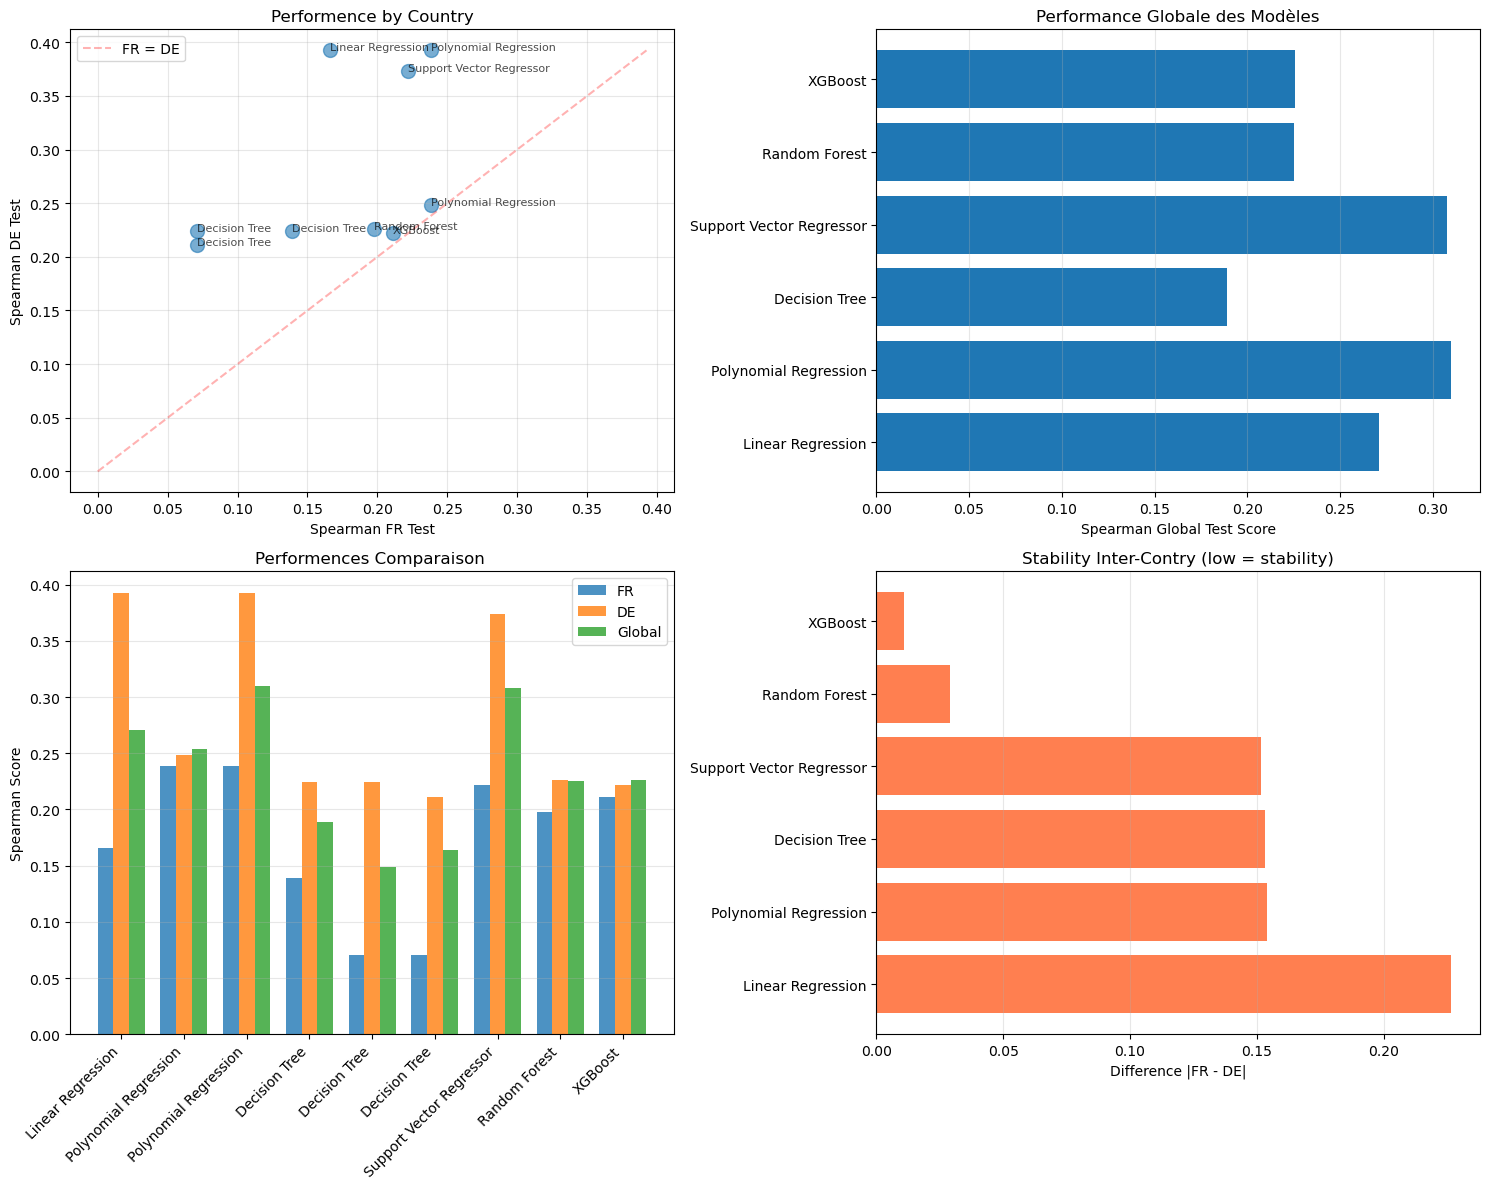

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].scatter(df_bias_variance["spearman_fr_test"], 
                   df_bias_variance["spearman_de_test"], 
                   s=100, alpha=0.6)
for i, model in enumerate(df_bias_variance["Model"]):
    axes[0, 0].annotate(model, 
                       (df_bias_variance.iloc[i]["spearman_fr_test"], 
                        df_bias_variance.iloc[i]["spearman_de_test"]),
                       fontsize=8, alpha=0.7)

max_val = max(df_bias_variance["spearman_fr_test"].max(), 
              df_bias_variance["spearman_de_test"].max())
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.3, label='FR = DE')
axes[0, 0].set_xlabel("Spearman FR Test")
axes[0, 0].set_ylabel("Spearman DE Test")
axes[0, 0].set_title("Performence by Country")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].barh(df_bias_variance["Model"], df_bias_variance["spearman_global_test"])
axes[0, 1].set_xlabel("Spearman Global Test Score")
axes[0, 1].set_title("Performance Globale des Modèles")
axes[0, 1].grid(True, alpha=0.3, axis='x')


x = np.arange(len(df_bias_variance))
width = 0.25
axes[1, 0].bar(x - width, df_bias_variance["spearman_fr_test"], width, label='FR', alpha=0.8)
axes[1, 0].bar(x, df_bias_variance["spearman_de_test"], width, label='DE', alpha=0.8)
axes[1, 0].bar(x + width, df_bias_variance["spearman_global_test"], width, label='Global', alpha=0.8)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(df_bias_variance["Model"], rotation=45, ha='right')
axes[1, 0].set_ylabel("Spearman Score")
axes[1, 0].set_title("Performences Comparaison ")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')


stability = abs(df_bias_variance["spearman_fr_test"] - df_bias_variance["spearman_de_test"])
axes[1, 1].barh(df_bias_variance["Model"], stability, color='coral')
axes[1, 1].set_xlabel("Difference |FR - DE|")
axes[1, 1].set_title("Stability Inter-Contry (low = stability)")
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Deep Learning

we already tested linear, polynomial, tree-based and boosting models on the engineered features.
Does a neural network capture non-linear patterns that classical ML models cannot?

#### What's Deep Learning?

It's important to distinguish:
- The classic Machine learning models: Not very deep (linear regression, SVR, random forest, XGBoost…).
- Deep Learning: neural networks with multiple layers, capable of approaching highly non-linear relationships.

**Reference**

Lago, J., De Ridder, F., & De Schutter, B. (2018).  
*Forecasting spot electricity prices: Deep learning approaches and empirical comparison of traditional algorithms.*  
Applied Energy, 221, 386–405.  
[https://www.sciencedirect.com/science/article/pii/S030626191830196X](https://www.sciencedirect.com/science/article/pii/S030626191830196X)


# Results

### Feed-forward neural networks for tabular regression

In our principal paper reference, our problem is called a **tabular regression**, indeed, each row of our dataset is an independent sample with no explicit temporal structure, so we are not in the case of time-series modelling.

For this type of data, the most natural deep learning model is a **feed-forward neural network**, also called a **Multi-Layer Perceptron (MLP)**. An MLP implements a non-linear regression of the form:

$$
\hat{y} = f_\theta(x)
$$

where $x$ is the input feature vector and $\hat{y}$ is the predicted day-ahead price (TARGET).  
The network is composed of:

- **An input layer** whose dimension equals the number of engineered features for France or Germany.
- **Several hidden layers** of fully connected (dense) neurons with non-linear activation functions, here typically $\text{ReLU}(z) = \max(0, z)$. These layers allow the network to model complex, non-linear interactions between features.
- **A single output neuron** with **linear activation**, providing a real-valued price prediction.

---

### What the neural network truly minimizes

During training, the neural network does **not** optimise the Spearman correlation directly.  
Instead, it learns its parameters $\theta$ by minimising a **differentiable loss function** (the Spearman correlation is not differentiable), usually the **Mean Absolute Error (MAE)** or **Mean Squared Error (MSE)**:

**MAE:**

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
$$

**MSE:**

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

---

More sophisticated architectures are also proposed by the article of J. Lago for electricity markets: **recurrent neural networks (RNN, LSTM/GRU)** to exploit hourly temporal dependencies, and **convolutional or hybrid CNN–LSTM models**.  
However, these models require access to high-frequency time series and lead to more complex experimental setups (sequence modelling, larger datasets, heavier hyperparameter tuning).

In this work, we deliberately focus on a **simple MLP for tabular regression**, trained on the **same engineered features** as our classical machine learning models.  
This choice keeps the comparison fair and transparent: any performance difference can be attributed to the modelling capacity of the neural network, rather than to a change in the input representation or in the evaluation protocol.


### Methodology: how we use Deep Learning in this project

#### Data and features used

For the deep learning experiments, we keep **exactly the same data preparation pipeline** as for the classical models.  
This includes:

- splitting the dataset into **FR** and **DE** subsets,  
- filling missing values with the **median**,  
- creating threshold-based variables and interaction features,  
- removing features with very low correlation to the target,  
- applying **standardisation** using StandardScaler.

Keeping the same preprocessing ensures a **fair and consistent comparison** between neural networks and the traditional machine learning approaches used earlier.

---

#### First neural network architecture

We train **one neural network per country** (FR and DE), which is consistent with the structure of our `pipeline_all` function.

A first simple baseline architecture is used:

- **FR model:**  
  Dense(64, ReLU) → Dense(32, ReLU) → Dense(1, linear)


- **DE model:**  
  Aproximately the same architecture.

The networks use:

- **He initialization** for the hidden layers, all the weights of the hidden layers are the same,
- **MSE** as the loss function,  
- **Adam** as the optimizer, it's what update the weights.

This architecture is intentionally lightweight to keep the comparison with classical models fair and interpretable.


### Regularisation and overfitting control

Because our dataset is relatively small, a neural network can easily **overfit**.  
To reduce this risk, we incorporate several regularisation mechanisms:

- **L2 weight decay** (`kernel_regularizer`):  
  penalises large weights during training, encouraging the network to learn smoother and simpler representations.

- **Dropout** between hidden layers (e.g. 0.2–0.3):  
  randomly deactivates a fraction of neurons at each training step, preventing the network from relying too heavily on specific connections.

- **Early stopping** based on validation loss:  
  stops training automatically when the model stops improving, avoiding unnecessary optimisation that would lead to overfitting.

These techniques help stabilise the training process and improve the model’s ability to generalise to unseen data.



### Deep learning implementation: libraries and integration with the pipeline

To implements the Deep learning models we use the library TensorFlows and Keras. However the Neurol Network build from Keras can't be use directly in our pipeline, especially because contrary to a model like LinearRegression() from scikit-learn, a keras model don't have some important features (.fit, .predict etc). The following class deals with that.

In [60]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow import keras
from tensorflow.keras import layers

class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hidden_units=(64, 32),
                 dropout_rate=0.0,
                 epochs=80,
                 batch_size=32,
                 verbose=0):
        
        # Hyperparameters
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def build_model(self, input_dim):
        model = keras.Sequential()

        # Hidden layers
        for units in self.hidden_units:
            model.add(layers.Dense(units, activation="relu",
                                   kernel_initializer="he_normal"))
            if self.dropout_rate > 0:
                model.add(layers.Dropout(self.dropout_rate))
        
        # Output layer
        model.add(layers.Dense(1, activation="linear"))

        model.compile(optimizer="adam", loss="mse")
        return model

    def fit(self, X, y):
        X = np.asarray(X).astype("float32")
        y = np.asarray(y).astype("float32")

        self.model = self.build_model(X.shape[1])

        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            validation_split=0.1,
            callbacks=[keras.callbacks.EarlyStopping(
                patience=10,
                restore_best_weights=True
            )]
        )
        return self

    def predict(self, X):
        X = np.asarray(X).astype("float32")
        preds = self.model.predict(X, verbose=0)
        return preds.flatten()


ModuleNotFoundError: No module named 'tensorflow'

### Experimental Evaluation of the Neural Network Model

In [ ]:
fr_model = KerasWrapper(epochs=50, batch_size=32)
de_model = KerasWrapper(epochs=50, batch_size=32)

results = pipeline_all(
    df=df,
    fr_model=fr_model,
    de_model=de_model,
    feature_engineering=True,
    standardisation=True,
    use_grid=False,
    k=3
)

display(results)
df_results.loc[len(df_results)] = {key: results[key] for key in allowed_cols}


NameError: name 'KerasWrapper' is not defined

We obtain a pretty low MSE comparing to the other models which is logical since it's the optimized metric by our model, however which is more surprising is that the obtain Spearman correlation is correct even if it's not the optimized metric.

## Optimization of hyperparameter for our Neural Network

##### Hyperparameters to optimize:
- **Hidden layer sizes**: The number of neurons in each hidden layer.
- **Dropout rate**: Dropout helps prevent overfitting by randomly deactivating a fraction of neurons during training.

- **Batch size**: Defines how many samples are processed before each weight update. It influences training stability and convergence speed, we notably wan't to increase Batch size because we find different results at each execution.


In [ ]:
param_grid = [
    {"hidden_units": (32, 16), "dropout": 0.0},
    {"hidden_units": (64, 32), "dropout": 0.0},
    {"hidden_units": (64, 32), "dropout": 0.2},
    {"hidden_units": (128, 64, 32), "dropout": 0.1},
    {"hidden_units": (64, 64), "dropout": 0.1},
]

results_dl = []

for params in param_grid:
    print("Testing:", params)

    fr_model = KerasWrapper(
        hidden_units=params["hidden_units"],
        dropout_rate=params["dropout"],
        epochs=80,
        batch_size=32,
        verbose=0
    )

    de_model = KerasWrapper(
        hidden_units=params["hidden_units"],
        dropout_rate=params["dropout"],
        epochs=80,
        batch_size=32,
        verbose=0
    )

    res = pipeline_all(
        df=df,
        fr_model=fr_model,
        de_model=de_model,
        feature_engineering=True,
        standardisation=True,
        use_grid=False,
        k=3
    )

    results_dl.append((params, res["spearman_global_test"]))

    results_dl


Testing: {'hidden_units': (32, 16), 'dropout': 0.0}


NameError: name 'KerasWrapper' is not defined

In [ ]:
results_dl

[]

### Our best MLP

In [ ]:
fr_model = KerasWrapper(
        hidden_units=(128, 64, 32),
        dropout_rate=0.1,
        epochs=80,
        batch_size=32,
        verbose=0
    )

de_model = KerasWrapper(
    hidden_units=(128, 64, 32),
    dropout_rate=0.1,
    epochs=80,
    batch_size=32,
    verbose=0
    )

res = pipeline_all(
    df=df,
    fr_model=fr_model,
    de_model=de_model,
    feature_engineering=True,
    standardisation=True,
    use_grid=False,
    k=3
    )

display(res)
df_results.loc[len(df_results)] = {key: res[key] for key in allowed_cols}

NameError: name 'KerasWrapper' is not defined

In [ ]:
df_results.sort_values(by="spearman_global_test", ascending=False)

,model_fr,model_de,spearman_global_test,spearman_fr_test,spearman_de_test,MSE,cv_mode,features_engineering,standardisation
2,"(StandardScaler(), PolynomialFeatures(include_...",LinearRegression(),0.310004,0.238286,0.392464,1.154545,kfold,True,True
6,"SVR(C=10, kernel='linear')","SVR(C=10, kernel='linear')",0.307933,0.221845,0.373597,1.195070,kfold,True,True
0,LinearRegression(),LinearRegression(),0.270993,0.165766,0.392464,1.177473,kfold,True,True
1,"(StandardScaler(), PolynomialFeatures(include_...","(StandardScaler(), PolynomialFeatures(include_...",0.253565,0.238286,0.248429,1.171172,kfold,True,True
8,"XGBRegressor(base_score=None, booster=None, ca...","XGBRegressor(base_score=None, booster=None, ca...",0.225757,0.210939,0.221836,1.199607,kfold,True,True
7,"(DecisionTreeRegressor(max_depth=8, max_featur...","(DecisionTreeRegressor(max_depth=10, max_featu...",0.225260,0.197303,0.226403,1.187467,kfold,True,True
3,"GridSearchCV(cv=5,\n estimator=Pip...","GridSearchCV(cv=5,\n estimator=Pip...",0.189236,0.138723,0.224031,1.233636,grid_search,True,True
5,"(DecisionTreeRegressor(max_depth=5, min_sample...","(DecisionTreeRegressor(max_depth=3, min_sample...",0.164329,0.070668,0.210689,1.179913,bagging,True,True
4,"DecisionTreeRegressor(max_depth=5, min_samples...","DecisionTreeRegressor(max_depth=3, min_samples...",0.149016,0.070668,0.224031,1.200960,kfold,True,True
